DSCI100 002, Group 18

Group Members: Jimmy Choy, Jennifer Law, Heather Lu, Elise Wong



**Sleep Disorders & Lifestyle**

**Introduction:**

Sleep is a fundamental aspect of human life and is critical to physical and mental health. However, many people suffer from sleep disorders, which involve problems with the quality, timing, and amount of sleep. The two most common sleep disorders are sleep apnea, where breathing frequently stops during sleep, and insomnia, where people have difficulty falling and staying asleep. Sleep disorders can be influenced by lifestyle and are often comorbid with chronic health disorders.

In our project, we will utilise the Sleep Health and Lifestyle Dataset. This dataset is a collection of information pertaining to sleep, lifestyle factors, cardiovascular health, and sleep disorders. Using the dataset, we aim to determine: “How can lifestyle and physiological measures be used to determine the absence or presence of diagnosed sleep disorders?” 
 

**Methods:**
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

**Preliminary exploratory data analysis**

In [12]:

url <- "https://drive.google.com/uc?export=download&id=1oltvINJVaLEg0raTdWG2IoFCf6w4h5vD"
download.file(url, destfile = "Sleep_health_and_lifestyle_dataset.csv")



In [28]:
library(tidyverse)
library(tidymodels)
sleep_data <- read_csv("Sleep_health_and_lifestyle_dataset.csv", skip = 1)

Rows: 748 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [11]:
colnames(sleep_data) <- make.names(colnames(sleep_data))

In [12]:
#removing NA values
sleep_data <- na.omit(sleep_data)

In [16]:
#separating bp column
sleep_data <- separate(sleep_data,
    col = Blood.Pressure,
    into = c("Systolic.BP", "Diastolic.BP"),
    sep = "/",
    convert = TRUE) 

In [17]:
#removing unwanted predictors
sleep_data_2 <- sleep_data |>
    select(-Gender, -Occupation, -BMI.Category)
head(sleep_data_2)

Person.ID,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Sleep.Disorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,27,6.1,6,42,6,126,83,77,4200,None
2,28,6.2,6,60,8,125,80,75,10000,None
3,28,6.2,6,60,8,125,80,75,10000,None
4,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
5,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
6,28,5.9,4,30,8,140,90,85,3000,Insomnia


In [18]:
#combining 'sleep apnea' and 'insomnia' into 'sleep disorders'
sleep_apnea_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Sleep Apnea") |>
select(-Sleep.Disorder)
sleep_apnea_tidy <- data.frame(sleep_apnea_untidy, Diagnosis = "Sleep Disorder")

insomnia_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Insomnia") |>
select(-Sleep.Disorder)
insomnia_tidy <- data.frame(insomnia_untidy, Diagnosis = "Sleep Disorder")

none_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "None") |>
select(-Sleep.Disorder)
none_tidy <- data.frame(none_untidy, Diagnosis = "None")

tidy_sleep_data <- rbind(sleep_apnea_tidy, insomnia_tidy, none_tidy)

head(tidy_sleep_data)

,Person.ID,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Diagnosis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,4,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
2,5,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
3,17,29,6.5,5,40,7,132,87,80,4000,Sleep Disorder
4,18,29,6.0,6,30,8,120,80,70,8000,Sleep Disorder
5,31,30,6.4,5,35,7,130,86,78,4100,Sleep Disorder
6,50,31,7.7,7,75,6,120,80,70,8000,Sleep Disorder


In [19]:
#splitting the data into training and test sets
sleep_split <- initial_split(tidy_sleep_data, prop = 0.75, strata = Diagnosis)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

**Table 1**

The table below represents the number of observations and percentages for each class in the training set.

In [20]:
summary_table_1 <- sleep_train |>
  group_by(Diagnosis) |>
  summarize(count = n(), percentage = n()/nrow(sleep_train)*100)

summary_table_1

Diagnosis,count,percentage
<chr>,<int>,<dbl>
None,164,58.57143
Sleep Disorder,116,41.42857


**Table 2**

The table below represents the means for each predictor in the training set.

In [21]:
summary_table_2 <- summarize(sleep_train, across(Age:Daily.Steps, mean))
summary_table_2

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.375,7.157143,7.346429,59.87857,5.346429,128.4536,84.65,70.13929,6850.357


**Visualization**

The bar plot below compares the mean stress level on a 1-10 scale (y-axis)--where a 1 is the lowest stress and 10 is the highest--between those with a sleep disorder diagnosis versus those without (x-axis) using the data from our dataset. We can observe that the mean stress level is greater for individuals with no sleep disorder diagnosis compared to those diagnosed.

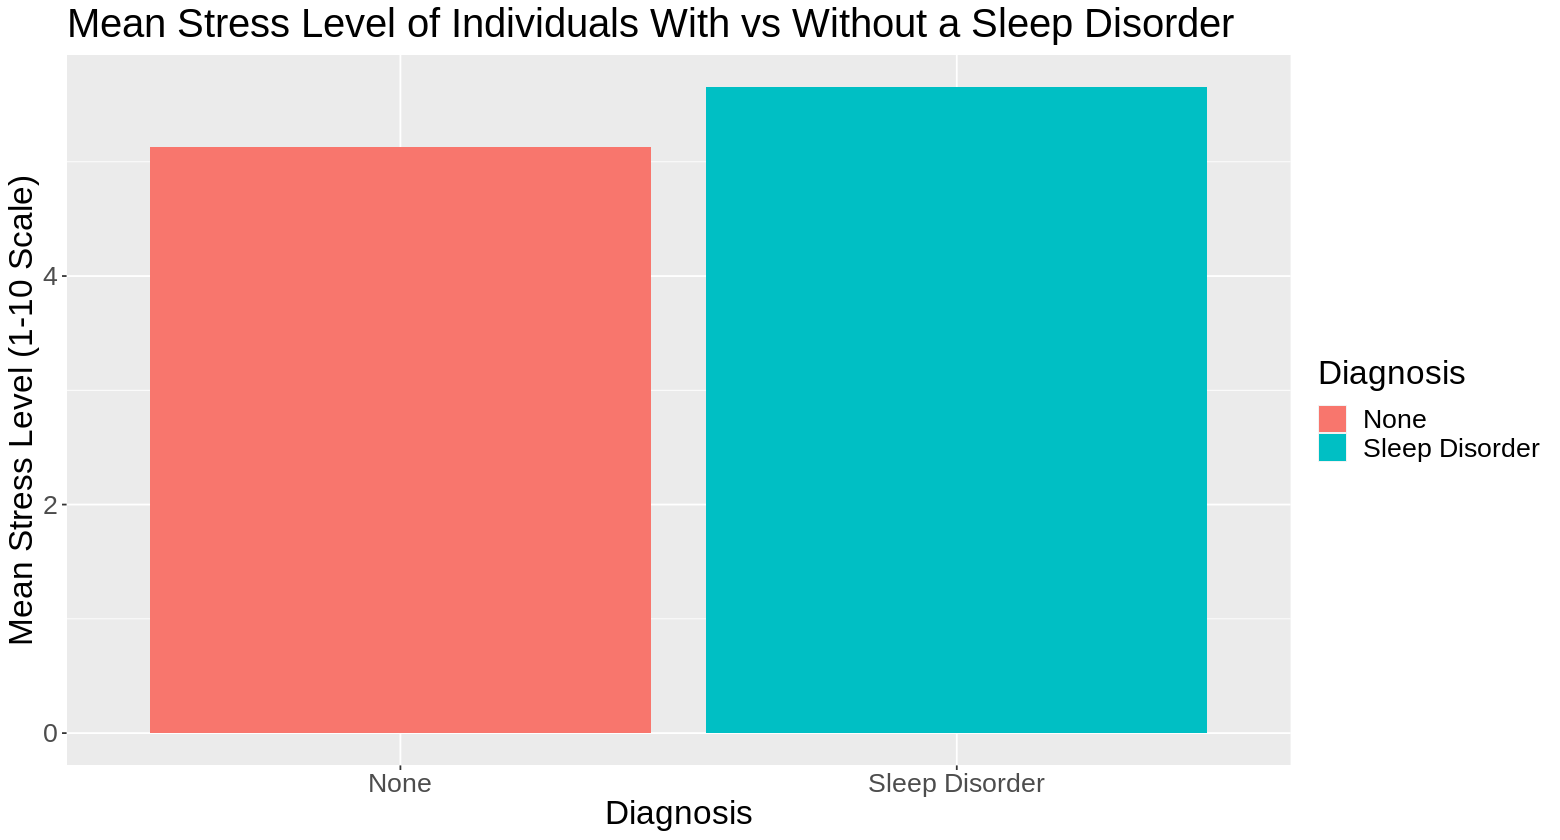

In [51]:
mean_stress_plot <- stress_mean |>
        ggplot(aes(y = Stress, x = Diagnosis, fill = Diagnosis))+
        geom_bar(stat = "identity", position = "dodge")+
        labs(x = "Diagnosis", y = "Mean Stress Level (1-10 Scale)")+
        theme(text = element_text(size = 20))+
        ggtitle("Mean Stress Level of Individuals With vs Without a Sleep Disorder")    
mean_stress_plot  

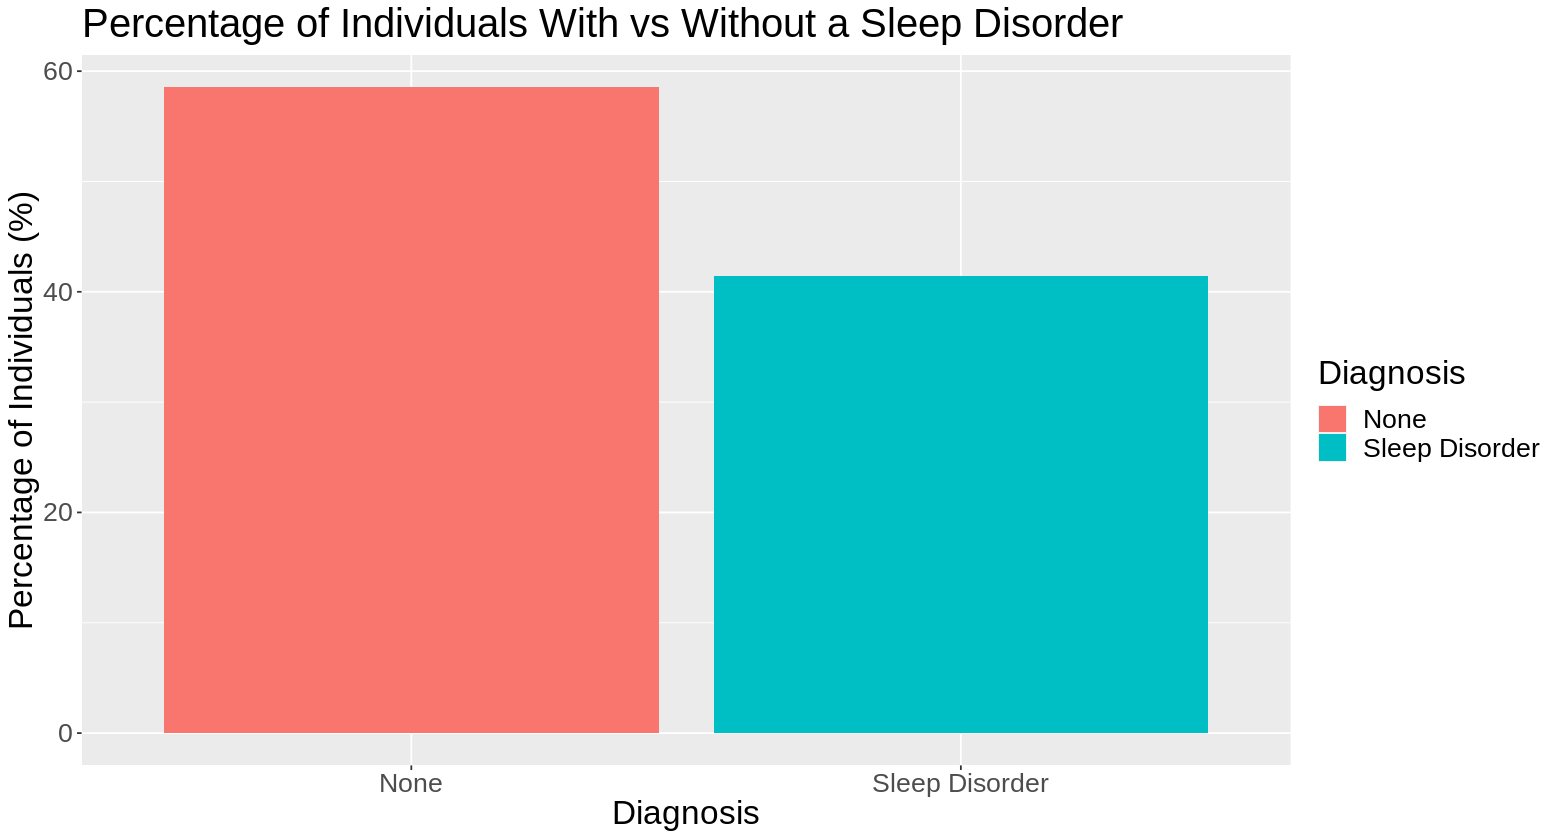

In [44]:
library(ggplot2)
library(repr)
library(tidyverse)
options(repr.plot.width = 13, repr.plot.height = 7)

sleep_percent_plot <- summary_table_1 |>
        ggplot(aes(y = percentage, x = Diagnosis, fill = Diagnosis))+
        geom_bar(stat = "identity", position = "dodge")+
        labs(x = "Diagnosis", y = "Percentage of Individuals (%)")+
        theme(text = element_text(size = 20))+
        ggtitle("Percentage of Individuals With vs Without a Sleep Disorder")
sleep_percent_plot  

In [49]:
stress_mean <- sleep_train |>
    group_by(Diagnosis) |>
    summarize(Stress = mean(Stress.Level))
stress_mean

Diagnosis,Stress
<chr>,<dbl>
None,5.128049
Sleep Disorder,5.655172


**Expected outcomes and significance:**

From our project, we expect to create a classification model that is able to predict an unclassified observation’s presence of a sleep disorder based on given physiological measures and lifestyle factors, as well as find the best K parameter that would provide the most accurate classifying model. These findings may help determine common factors associated with sleep disorder patients and which factors are strongly or weakly linked.

We expect individuals who report the shortest sleep duration, the lowest levels of physical activity, the highest stress levels, and clinically unhealthier physiological measurements to have the highest occurrences of sleep disorder diagnosis.

**Future questions our project could lead to are:**
- What forms of interventions could be implemented to help the populations most affected by sleep disorders?
- Is there one factor that best predicts the presence of sleep disorders?
- Are there any other factors relating to lifestyle habits that also correlate with sleep disorder diagnosis?


**References**
Tharmalingam, L. (2023, May 26). Sleep health and lifestyle dataset. Kaggle.    https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset 